In [29]:
import pandas as pd
import numpy as np
import cv2
from skimage import color
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
import time, os
import warnings
from sklearn import svm
warnings.filterwarnings('ignore')

In [30]:
class GaborFilter:
    def __init__(self,orientation, gabor_sizes):
#         self.image = image
        self.orientations = orientation
        self.gabor_sizes = gabor_sizes
    def filter_image(self,image):
        filtered_images = []
        for gabor_size in self.gabor_sizes:
            for orientation in orientations:
                g_kernel = cv2.getGaborKernel((gabor_size,gabor_size), 4.6, orientation, 11.0, 1.8, 0, ktype=cv2.CV_32F)
#                 plt.imshow(resize(color.rgb2gray(cv2.filter2D(img, cv2.CV_8UC3, g_kernel)), (500,500)))
#                 plt.imshow(g_kernel)
#                 plt.show()
#                 print(g_kernel)
                filtered_images.append(resize(color.rgb2gray(cv2.filter2D(img, cv2.CV_8UC3, g_kernel)), (500,500)))

        return np.stack(filtered_images ,axis=0)    

In [31]:
class Pooling:
    def __init__(self,filter_size,stride ,  pooling='max'):
        self.filter_size = filter_size
        self.stride = stride
    def pool(self,image):
        hight = int( 1 + (image.shape[1] - self.filter_size) / self.stride)
        width = int( 1 + (image.shape[2] - self.filter_size) / self.stride)
        channel = image.shape[0]
        pooled_image = np.zeros((channel, hight,width ))
        for h in range(hight):
            for w in range(width):
                for c in range(channel):
                    vert_start = h * self.stride
                    vert_end = vert_start + self.filter_size
                    horiz_start = w * self.stride
                    horiz_end = horiz_start + self.filter_size
                    pooled_image[c,h,w] = np.max(image[c, vert_start:vert_end, horiz_start:horiz_end])
        return pooled_image

In [44]:
class SpikingLayer:
    def __init__(self,input_size,channel, stride, n_filter, filter_size, k_winner ):
        self.n_filter = n_filter
        self.filter_size = filter_size
        self.input_spikes = None
        self.image = None
        self.stride = stride
        self.k_winner = k_winner
        self.weights = {}
        self.neuron_potential = {}
        self.receptive_fields = {}
        self.Thershold = 5
        self.resting_potential = 0
        self.channel = channel
        for i, s in zip(range(n_filter),filter_size):
            self.weights[i] = np.random.randn(4,s,s) + 5
            hight = int( 1 + (input_size - s) / self.stride)
            self.neuron_potential[i] = [0] * np.square(int( 1 + (input_size - s) / self.stride))
#             print(int( 1 + (input_size - s) / self.stride))
            self.receptive_fields[i] = [(h * self.stride, w * self.stride) for h in range(hight) for w in range(hight)  ]
            print(len(self.receptive_fields[i]))
            print(len(self.neuron_potential[i]))
        self.winners = {}
        for i in range(self.n_filter):
            self.winners[i] = 0
    
       
    def in_receptive_field(self,spiked_neuron, neuron, f):
        if self.receptive_fields[f][neuron][0] <= spiked_neuron[1] < self.receptive_fields[f][neuron][0] + self.filter_size[f] and self.receptive_fields[f][neuron][1] <= spiked_neuron[2] < self.receptive_fields[f][neuron][1] + self.filter_size[f]:
            return True, spiked_neuron[1] - self.receptive_fields[f][neuron][0] , spiked_neuron[2] - self.receptive_fields[f][neuron][1]
        else: return False, -1, -1
        
       
    def STDP(self,n_th, f, neuron, reward):
        if reward == 0: reward = -1
        print('reward : ', reward)    
        rcp = self.receptive_fields[f][neuron]
        for c in range(self.channel):
            for i in range(self.filter_size[f]):
                for j in range(self.filter_size[f]):
                    idx = self.input_spikes.index((self.image[c,rcp[0] + i,rcp[1] + j], rcp[0] + i,rcp[1] + j,c) )
                    if idx <= n_th:
                        self.weights[f][c][i][j] += np.exp(-(n_th - idx)) * reward
#                         print('weight change : ',(1 - self.weights[f][c][i][j]) * self.weights[f][c][i][j] / 10  )
#                         print('weight : ',  self.weights[f][c][i][j])
                    else: self.weights[f][c][i][j] -= np.exp(-(idx - n_th)) * reward
                    
         #input spike : intensity , row, column, map(gabor)
    def forward(self, label):
        spiked = False
        print ('lable : ', label)
        for n_th, spiked_neuron in enumerate(self.input_spikes):
            if spiked == False:
                for f in range(self.n_filter):
                    if spiked == False:
                        for neuron , potential in enumerate(self.neuron_potential[f]):
        #                     print('n_th : ' ,n_th, 'f: ', f, 'neuron', neuron)
                            in_rcp_fld , i, j = self.in_receptive_field(spiked_neuron, neuron, f)
                            if in_rcp_fld:
                                self.neuron_potential[f][neuron] += self.weights[f][spiked_neuron[3]][i][j] 
                                self.neuron_potential[f][neuron] = np.clip(self.neuron_potential[f][neuron],-3,6)
                                if self.neuron_potential[f][neuron] > self.Thershold :
                                    self.neuron_potential[f][neuron] = self.resting_potential
                                    if self.winners[f] < self.k_winner:
        #                                 print(f, ' ', neuron)
                                        self.winners[f] += 1
                                        print('model pred : ' ,f + 1)
                                        self.STDP(n_th, f, neuron, label == (f + 1))
                                        spiked = True
                                        break
        return f + 1

    def foward_test(self):
        for n_th, spiked_neuron in enumerate(self.input_spikes):
            for f in range(self.n_filter):
                for neuron , potential in enumerate(self.neuron_potential[f]):
#                     print('n_th : ' ,n_th, 'f: ', f, 'neuron', neuron)
                    in_rcp_fld , i, j = self.in_receptive_field(spiked_neuron, neuron, f)
                    if in_rcp_fld:
                        self.neuron_potential[f][neuron] += self.weights[f][spiked_neuron[3]][i][j] 
                        self.neuron_potential[f][neuron] = np.clip(self.neuron_potential[f][neuron],-3,6)
                        if self.neuron_potential[f][neuron] > self.Thershold :
                            self.neuron_potential[f][neuron] = self.resting_potential
                            
        feature_vector = [potential  for i in range(self.n_filter) for potential in self.neuron_potential[i]]   
        
        return feature_vector
        
    def intensity_to_latency(self,image):
        intensities = []
        self.image = image
        for c in range(image.shape[0]):
            for i in range(image.shape[1]):
                for j in range(image.shape[2]):
                    intensities.append((image[c,i,j], i , j, c))
        
        self.input_spikes = sorted(intensities, key=lambda val: val[0],reverse=True)
        
    def reset_neurons(self):
        for f in range(self.n_filter):
            self.neuron_potential[f] = [0] * len(self.neuron_potential[f])
        for i in range(self.n_filter):

            self.winners[i] = 0
    

In [64]:

img = io.imread('down_arrow.jpg')
orientations = [0,np.pi / 2, np.pi / 4, 3 * np.pi / 4]
# orientations = [ np.pi / 4]
gabor_sizes = [20]
filter_size = 15
stride = 10
gabor = GaborFilter(orientations, gabor_sizes)
pooling = Pooling(filter_size, stride)
sp = SpikingLayer(input_size = 49, channel = 4,stride = 5, n_filter = 4, filter_size = [20,20,20,20], k_winner=1)

36
36
36
36
36
36
36
36


In [65]:
img = gabor.filter_image(img)
# plt.imshow(img)
img = pooling.pool(img)
img.shape

(4, 49, 49)

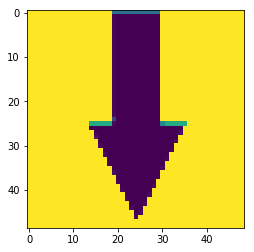

In [66]:

plt.imshow(img[1])

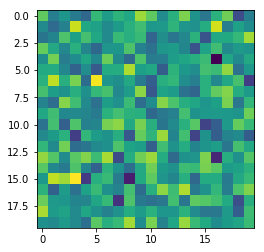

In [67]:
# sp2 = SpikingLayer(input_size = 33, channel = 4,stride = 1, n_filter = 4, filter_size = [5,10,15,20], k_winner=1)
# sp2.weights = sp.weights
plt.imshow(sp.weights[2][1])

In [68]:
# > 1 < 2 up 3 down 4
mapp = np.array([[1,1,1,1,2],[3,3,3,2,4], [1,3,1,1,4], [4,3,3,4,1],[3,3,2,3,3]])
pos = (4,1)
food  = (3,3)

In [69]:
def move_to(move):
    
    if move == 1:
        return io.imread('right_arrow.jpg')
    elif move == 2:
        return io.imread('left_arrow.jpg')
    elif move == 3:
        return io.imread('up_arrow.jpg')
    else:
        return io.imread('down_arrow.jpg')
def next_move_pos(pos,move):
    if move == 1: return (pos[0] , pos[1] + 1)  
    elif move == 2: return (pos[0] , pos[1] -1)
    elif move == 3: return (pos[0] - 1, pos[1])
    else : return (pos[0] + 1, pos[1])
    

In [70]:
next_move = io.imread('up_arrow.jpg')
move = 3
for _ in range(0,5):
    for i in range(0,6):
        next_move = gabor.filter_image(next_move)
        next_Move = pooling.pool(next_move)
        sp.intensity_to_latency(next_move)
        sp.reset_neurons()
        move = sp.forward(move)
        pos = next_move_pos(pos, move) 
        next_move = move_to(move) 
        print('move : ', move)
        if pos[0] > 4 or pos[1] > 4 or pos[0] < 0 or pos[1] < 0: 
            pos  = (4,1)
            break
        print(pos)
    
    

lable :  3
model pred :  1
reward :  -1
move :  4
lable :  4
model pred :  3
reward :  -1
move :  4
lable :  4
model pred :  3
reward :  -1
move :  4
lable :  4
model pred :  1
reward :  -1
move :  4
lable :  4
model pred :  1
reward :  -1
move :  4


In [267]:
##test on train
X = []
y = []
for filename in os.listdir('./train_cat_vs_dog'):
    if filename.endswith(".jpg") and int(filename.split('.')[1]) <= 100:
        label = filename.split('.')[0] == 'cat'
        img = io.imread('./train_cat_vs_dog/' + filename)
        img = gabor.filter_image(img)
        img = pooling.pool(img)
        sp.intensity_to_latency(img)
        sp.reset_neurons()
        X.append(sp.foward_test())
        y.append(label)

In [268]:
##train classifier
clf = svm.SVC()
clf.fit(X, y)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [205]:
## test on testset
X_test = []
y_test = []
for filename in os.listdir('./test'):
    if filename.endswith(".jpg") and int(filename.split('.')[1]) <= 3050 :
        label = filename.split('.')[0] == 'cat'
        img = io.imread('./test/' + filename)
        img = gabor.filter_image(img)
        img = pooling.pool(img)
        sp.intensity_to_latency(img)
        sp.reset_neurons()
        X_test.append(sp.foward_test())
        y_test.append(label)

In [71]:
pred = clf.predict(X)

NameError: name 'clf' is not defined

In [270]:
np.sum(pred == y)

202

In [208]:
pred

array([False,  True,  True, False,  True,  True, False, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True, False, False, False,  True,  True,  True, False,  True,
        True, False,  True,  True, False,  True,  True, False,  True,
       False, False, False,  True,  True, False,  True,  True, False,
        True,  True, False,  True, False, False,  True,  True,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False,  True, False,
        True,  True, False,  True, False,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False,

In [209]:
pred_test = clf.predict(X_test) 

In [210]:
np.sum(pred_test == y_test)

43

In [211]:
pred_test

array([False,  True, False, False,  True, False, False,  True, False,
        True, False, False, False, False, False, False, False, False,
       False,  True,  True, False,  True,  True,  True, False, False,
        True, False,  True, False,  True, False, False, False, False,
       False, False,  True, False, False, False, False,  True, False,
       False, False, False, False, False, False,  True, False,  True,
       False,  True, False, False, False, False, False, False, False,
        True,  True,  True, False,  True,  True,  True, False,  True,
       False, False, False,  True,  True, False, False,  True,  True,
        True,  True,  True,  True, False,  True, False, False, False,
       False, False, False, False, False,  True, False, False, False,
        True])

In [212]:
sp.neuron_potential

{0: [1.5119885730715967,
  1.5164934140433137,
  1.5181062441475448,
  1.521478856172164,
  1.5182862396820453,
  1.5349378048101303,
  1.5200093020821053,
  1.515949376920988,
  1.5001585251188339,
  1.5276727857265113,
  1.5245509031383382,
  1.5255877435386196,
  1.5073817464647732,
  1.5288242794817748,
  1.511918030199905,
  1.5249953587781035,
  1.5221951721724458,
  1.5187452338571847,
  1.5260553995139137,
  1.5175127968448558,
  1.5140023372644231,
  1.5234715056604673,
  1.5141698522702607,
  1.5226985743742225,
  1.5259306646700965,
  1.5264505844814433,
  1.518212109988506,
  1.525694544938098,
  1.5239892498801557,
  1.526843575977,
  1.5162876749086598,
  1.5260219673766264,
  1.5286210814305168,
  1.5160074161814594,
  1.5268710399485634,
  1.5243805625460176],
 1: [1.4718240553410464,
  1.4812507474786705,
  1.4817152509365357,
  1.4757265452420973,
  1.4789684838445385,
  1.4854431106232762,
  1.47482861643335,
  1.4752939658226423,
  1.4837068526294115,
  1.4760558809

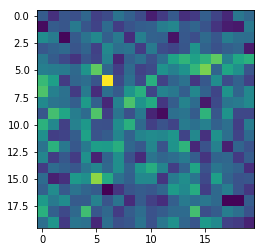

In [191]:
plt.imshow(sp.weights[2][1])

In [193]:
X[-1]

[1.4286982169681537,
 1.438565316305572,
 1.4380680844313436,
 1.4300253602561466,
 1.427883274046152,
 1.4274172565303647,
 1.4374316260861302,
 1.4359959773278224,
 1.4330222108391089,
 1.424968133849666,
 1.4328519986007349,
 1.4183943560924683,
 1.4318138213875047,
 1.4322823427297855,
 1.425319591426121,
 1.4290691345780548,
 1.4281398820748958,
 1.4174594315639153,
 1.4227656650287646,
 1.4310052165774207,
 1.4301056347403358,
 1.4349044918504854,
 1.43526345963755,
 1.4233311133032571,
 1.4292887280157176,
 1.420312692252875,
 1.4254857477844425,
 1.4372247760165744,
 1.431120565028627,
 1.4194676151164902,
 1.4237993981105135,
 1.4206753896277495,
 1.4260480019177053,
 1.4146586145733442,
 1.4278793560277065,
 1.442760516652535,
 1.4550183532947296,
 1.4560535992599555,
 1.449717084450458,
 1.452897837782324,
 1.4631568687947747,
 1.4553779691131066,
 1.4546520832901964,
 1.4612884617170312,
 1.4572895530916028,
 1.455116315315677,
 1.4548233917333127,
 1.4626601619303157,
 1.4

In [194]:
X[0]

[1.4309395908922218,
 1.4390929393497534,
 1.4250783613016265,
 1.4393595988786512,
 1.430501878892068,
 1.425399972540312,
 1.432505438026459,
 1.4253804977576567,
 1.4236259608119772,
 1.442947387022916,
 1.4296377490055372,
 1.4343369068257126,
 1.4194376598295033,
 1.44112845085673,
 1.4239438705504992,
 1.434506976065034,
 1.4260938313447231,
 1.439761462752848,
 1.4311121288874278,
 1.4222698955777258,
 1.4332180457263322,
 1.4329728268274877,
 1.4311108527153142,
 1.4267846710853112,
 1.4293419371087146,
 1.4257540496633025,
 1.4315931753114612,
 1.4319534220823191,
 1.4219647239407152,
 1.419094242180589,
 1.432232992220997,
 1.4373388131307727,
 1.425632497006437,
 1.4291733210369613,
 1.4287053266132503,
 1.429488716747378,
 1.4627189034634012,
 1.452178095126086,
 1.4503559958108956,
 1.4524509435535329,
 1.4554982474469773,
 1.4472741163749798,
 1.4431105466730993,
 1.46018948613627,
 1.4591045642014528,
 1.446212623385552,
 1.4497908807863955,
 1.4536538736143119,
 1.45172